In [1]:
alice = []

with open ("./cantrbry/alice29.txt", "r") as f :
    alice = f.read()

lcet = []

with open ("./cantrbry/lcet10.txt", "r") as f :
    lcet = f.read()

plrabn12 = []

with open ("./cantrbry/plrabn12.txt", "r") as f :
    plrabn12 = f.read()

asyoulik = []

with open ("./cantrbry/asyoulik.txt", "r") as f :
    asyoulik = f.read()


In [ ]:
#@title read binary files

kennedy = []
ptt5 = []
sum_file = []

with open ("./kennedy.xls", "rb") as f :
    kennedy = f.read()

with open ("./ptt5", "rb") as f :
    ptt5 = f.read()

with open ("./sum", "rb") as f :
    byte = f.read(1)
    while byte:
        sum_file.append(byte)
        # Read the next byte
        byte = f.read(1)


In [2]:
#@title linear

TOTAL_CHAR = 2**16
import random

# derivative first half (log P(s) / alpha)

import sys
import pickle
import math
import pdb
import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=400)

# n = 4   # number of letters as context
MAX_N = 4
MAX_UPDATE_RATIO = 0.4
MINIMUM_ALPHA = 1e-10

class Blending_with_linear_param:
    max_f = 0
    total_score = 0
    count = 0
    logs = []
    logs_score_individual = []
    zero_prob = 0

    def __init__(self, max_f):
        self.max_f = max_f
        self.logs = []
        logs_score_individual = []
        self.zero_prob = 0
        self.total_score = 0
        return None

    def derivative_of_P_to_alpha(self, alpha_matrix, beta_matrix, model, prefix, x):

        n = len(prefix)
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)
        if prefix in model:
            ms = sum(model[prefix].values())
            us = len(model[prefix])
            if x in model[prefix]:
                ms_x = model[prefix][x]
            else:
                ms_x = 0
        else:
            ms = 0
            us = 0
            ms_x = 0

        eq1 = (beta-ms_x) / (ms+alpha)**2

        if len(prefix) == 0:
            eq2 = 0 # (ms-us*beta) / (ms+alpha)**2 * self.blend(alpha_matrix, beta_matrix, "", x, model, n)
            eq3 = 0
        else:
            next_prefix = prefix[1:]
            eq2 = (ms-us*beta) / (ms+alpha)**2 * self.blend(alpha_matrix, beta_matrix, next_prefix, x, model)
            eq3 = (alpha + us*beta) / (ms+alpha) * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, model, next_prefix, x)

        return eq1 + eq2 + eq3

    def derivative_of_P_to_beta(self, alpha_matrix, beta_matrix, model, prefix, x):

        n = len(prefix)
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)
        if prefix in model:
            ms = sum(model[prefix].values())
            us = len(model[prefix])
            if x in model[prefix]:
                ms_x = model[prefix][x]
            else:
                ms_x = 0
        else:
            ms = 0
            us = 0
            ms_x = 0

        eq1 = -1 / (ms+alpha)
        if len(prefix) == 0:
            eq2 = 0 # us / (ms+alpha) * self.blend(alpha_matrix, beta_matrix, "", x, model, n)
            eq3 = 0
        else:
            next_prefix = prefix[1:]
            eq2 = us / (ms+alpha) * self.blend(alpha_matrix, beta_matrix, next_prefix, x, model)
            eq3 = (alpha + us*beta) / (ms+alpha) * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, model, next_prefix, x)

        return eq1 + eq2 + eq3


    def update_param(self, alpha_matrix, beta_matrix, prefix, x, model):
        learning_rate = 0.003
        n = len(prefix)
        # add a computation for alpha beta
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f
        param_derivative_mapping = [1, f]
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x, model)
        if prob == 0:
            return
        allowed_beta_minimum = 0
        allowed_beta_maximum = 1

        # new
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, model, prefix, x)
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, model, prefix, x)
        beta_update = learning_rate * derivative_beta
        alpha_update = learning_rate * derivative_alpha
        factor = 1

        allowed_alpha_maximum = (alpha_matrix[n][0] + max(0, alpha_matrix[n][1]*self.max_f)) * (1+MAX_UPDATE_RATIO)
        allowed_alpha_minimum = (alpha_matrix[n][0] + min(0, alpha_matrix[n][1]*self.max_f)) * (1-MAX_UPDATE_RATIO)
        allowed_alpha_minimum = max(MINIMUM_ALPHA, allowed_alpha_minimum)

        allowed_beta_minimum = (beta_matrix[n][0] + min(0, beta_matrix[n][1]*self.max_f)) * (1-MAX_UPDATE_RATIO)
        allowed_beta_maximum = (beta_matrix[n][0] + max(0, beta_matrix[n][1]*self.max_f)) * (1+MAX_UPDATE_RATIO)
        allowed_beta_maximum = min(allowed_beta_maximum, 1)
        allowed_beta_minimum = max(MINIMUM_ALPHA, allowed_beta_minimum)

        # # print(allowed_alpha_minimum, allowed_alpha_maximum)

        # old_alpha_0 = alpha_matrix[n][0]
        # old_alpha_1 = alpha_matrix[n][1]
        # old_beta_0 = beta_matrix[n][0]
        # old_beta_1 = beta_matrix[n][1]

        for ind, derivative in zip(range(len(param_derivative_mapping)), param_derivative_mapping):
            beta_matrix[n][ind] += beta_update * derivative
            alpha_matrix[n][ind] += alpha_update * derivative

        # if n == 5:
        #     print(allowed_alpha_minimum, allowed_alpha_maximum)
        #     print("values:", alpha, beta, prob, alpha_update, beta_update, f)

        # restrict param for beta
        beta_matrix[n][0] = max(allowed_beta_minimum, min(allowed_beta_maximum, beta_matrix[n][0]))

        if beta_matrix[n][0] + self.max_f * beta_matrix[n][1] > allowed_beta_maximum:
            beta_matrix[n][1] = (allowed_beta_maximum - beta_matrix[n][0]) / self.max_f
        elif beta_matrix[n][0] + self.max_f * beta_matrix[n][1] < allowed_beta_minimum:
            beta_matrix[n][1] = (allowed_beta_minimum-beta_matrix[n][0]) / self.max_f

        # max_beta = max(beta_matrix[n][0], beta_matrix[n][0]+self.max_f*beta_matrix[n][1])
        # restrict param for alpha
        alpha_matrix[n][0] = max(allowed_alpha_minimum, min(allowed_alpha_maximum, alpha_matrix[n][0]))

        if alpha_matrix[n][0] + self.max_f * alpha_matrix[n][1] < allowed_alpha_minimum:
            alpha_matrix[n][1] = (allowed_alpha_minimum-alpha_matrix[n][0]) / self.max_f
        elif alpha_matrix[n][0] + self.max_f * alpha_matrix[n][1] > allowed_alpha_maximum:
            alpha_matrix[n][1] = (allowed_alpha_maximum-alpha_matrix[n][0]) / self.max_f

        # if beta_update == 0 or alpha_update == 0:
        #     return

        # # compute factor
        # if f == 0:
        #     factor = min((alpha_matrix[n][0] - old_alpha_0) / (alpha_update), (beta_matrix[n][0] - old_beta_0) / (beta_update),)
        # else:
        #     factor = min((alpha_matrix[n][0] - old_alpha_0) / (alpha_update), (alpha_matrix[n][1] - old_alpha_1) / (alpha_update*f),
        #                 (beta_matrix[n][0] - old_beta_0) / (beta_update), (beta_matrix[n][1] - old_beta_1) / (beta_update*f))

        # assert(factor > 0)


    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix, model):
        n = len(prefix)
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        param_derivative_mapping = [1, f]
        # alpha1 = np.dot(alpha_matrix[n], param_derivative_mapping)
        # beta1 = np.dot(beta_matrix[n], param_derivative_mapping)

        alpha = alpha_matrix[n][0] + f*  alpha_matrix[n][1]
        beta = beta_matrix[n][0] + f*  beta_matrix[n][1]

        #beta = max(0, min(1, beta))
        # alpha = max(-beta, alpha)

        return (alpha, beta)

    def build_model_with_train(self, data, alpha_matrix, beta_matrix, word_file, n):
        """
        Build n-gram model of the words in  words_lang.txt
        """
        n_grams = {}
        # read in all n+1 grams
        n_plus_1_gram_counts = {}
        for word in data:
            word_org = word
            # update n-gram
            # word = "^" * n + word + "$"
            for i in range(len(word) - n):

                n_plus_1_gram = word[i:i + n + 1]
                score = self.letter_prob_score (alpha_matrix, beta_matrix, n_plus_1_gram[:-1], n_plus_1_gram[-1], n_grams, n)
                self.total_score += score
                # self.total_score += self.blend (alpha_matrix, beta_matrix, n_plus_1_gram[:-1], n_plus_1_gram[-1], n_grams, n)
                self.count += 1
                self.logs.append(-self.total_score/self.count)
                self.logs_score_individual.append(score)

                # n_plus_1_gram = word[i:i + n + 1]
                # for N in range(n, -1, -1):
                #     x = n_plus_1_gram[-1]
                #     next_n = n_plus_1_gram[:-1]

                #     self.update_param(alpha_matrix, beta_matrix, next_n, x, n_grams)

                #     n_plus_1_gram = n_plus_1_gram[1:]

                n_plus_1_gram = word[i:i + n + 1]
                for N in range(n+1):
                    x = n_plus_1_gram[-1]
                    next_n = n_plus_1_gram[-1-N:-1]
                    self.update_param(alpha_matrix, beta_matrix, next_n, x, n_grams)



                n_plus_1_gram = word[i:i + n + 1]
                for N in range(n, -1, -1):
                    x = n_plus_1_gram[-1]
                    next_n = n_plus_1_gram[:-1]

                    if next_n not in n_grams:
                        n_grams[next_n] = {}

                    if x not in n_grams[next_n]:
                        n_grams[next_n][x] = 1
                    else:
                        n_grams[next_n][x] += 1

                    n_plus_1_gram = n_plus_1_gram[1:]


        return n_grams

    def offline_optimisation(self, data, alpha_matrix, beta_matrix, word_file, model, n):
         for word in data:
            for i in range(len(word) - n):
                n_plus_1_gram = word[i:i + n + 1]
                for N in range(n+1):
                    x = n_plus_1_gram[-1]
                    next_n = n_plus_1_gram[-1-N:-1]
                    self.update_param(alpha_matrix, beta_matrix, next_n, x, model)

    def blend(self, alpha_matrix, beta_matrix, prefix, x, model):
        prob = 0

        # compute alpha and beta
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)
        possible_x = TOTAL_CHAR

        # first half of algorithm
        if prefix in model:
            us = len(model[prefix])
            ms = sum(model[prefix].values())
            base = (len(model[prefix])*beta + alpha) / (sum(model[prefix].values()) + alpha)
            if x in model[prefix]:
                prob += (model[prefix][x] - beta) / (sum(model[prefix].values()) + alpha)
        else:
            base = (0 + alpha) / (0 + alpha)

        if len(prefix) == 0:
            prob += base / possible_x
        else:
            prev = self.blend(alpha_matrix, beta_matrix, prefix[1:], x, model)
            prob += base * prev

        prob = prob

        return prob


    def word_prob_blend(self, alpha_matrix, beta_matrix, word, model, n):
        word = "^" * n + word.strip() + "$"
        pos = n  # char after n ^
        log_likelihood = 0
        # print ("   ", end="")
        while pos < len(word):
            prefix = word[pos - n:pos]
            prob = self.blend(alpha_matrix, beta_matrix, prefix, word[pos], model)
            # print(prefix, word[pos], prob)
            if prob:
                log_likelihood += math.log2(prob)
            pos += 1


        return log_likelihood / (len(word) - 1)  # didn't guess "^"

    def letter_prob_score(self, alpha_matrix, beta_matrix, prefix, x, model, n):
        prob = self.blend(alpha_matrix, beta_matrix, prefix, x, model)
        # print(prefix, word[pos], prob)
        if prob:
            return math.log2(prob)
        else:
            self.zero_prob += 1
            print("error")
            return 0


In [3]:
#@title linear v2

class Blending_with_linear_param_v2(Blending_with_linear_param):
    max_f = 0
    max_n = 0

    def __init__(self, max_f, max_n):
        self.max_n = max_n
        super().__init__(max_f)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x, model):
        learning_rate = 0.003
        n = len(prefix)
        # add a computation for alpha beta
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f
        param_derivative_mapping = [1, f, n]
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x, model)
        if prob == 0:
            return

        # new
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, model, prefix, x)
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, model, prefix, x)
        beta_update = learning_rate * derivative_beta
        alpha_update = learning_rate * derivative_alpha
        factor = 1

        allowed_alpha_maximum = (alpha_matrix[0] + max(0, alpha_matrix[1]*self.max_f) + max(0, alpha_matrix[2]*self.max_n)) * (1+MAX_UPDATE_RATIO)
        allowed_alpha_minimum = (alpha_matrix[0] + min(0, alpha_matrix[1]*self.max_f) + min(0, alpha_matrix[2]*self.max_n)) * (1-MAX_UPDATE_RATIO)
        allowed_alpha_minimum = max(MINIMUM_ALPHA, allowed_alpha_minimum)

        allowed_beta_maximum = (beta_matrix[0] + max(0, beta_matrix[1]*self.max_f) + max(0, beta_matrix[2]*self.max_n)) * (1+MAX_UPDATE_RATIO)
        allowed_beta_minimum = (beta_matrix[0] + min(0, beta_matrix[1]*self.max_f) + min(0, beta_matrix[2]*self.max_n)) * (1-MAX_UPDATE_RATIO)
        allowed_beta_maximum = min(allowed_beta_maximum, 1)
        allowed_beta_minimum = max(MINIMUM_ALPHA, allowed_beta_minimum)

        for ind, derivative in zip(range(len(param_derivative_mapping)), param_derivative_mapping):
            beta_matrix[ind] += beta_update * derivative
            alpha_matrix[ind] += alpha_update * derivative

        # restrict param for beta
        beta_matrix[0] = max(allowed_beta_minimum, min(allowed_beta_maximum, beta_matrix[0]))

        if beta_matrix[0] + self.max_f * beta_matrix[1] > allowed_beta_maximum:
            beta_matrix[1] = (allowed_beta_maximum - beta_matrix[0]) / self.max_f
        elif beta_matrix[0] + self.max_f * beta_matrix[1] < allowed_beta_minimum:
            beta_matrix[1] = (allowed_beta_minimum-beta_matrix[0]) / self.max_f

        if beta_matrix[0] + max(self.max_f * beta_matrix[1], 0) + beta_matrix[2]*self.max_n > allowed_beta_maximum:
            beta_matrix[2] = (allowed_beta_maximum - beta_matrix[0] - max(self.max_f * beta_matrix[1], 0)) / self.max_n
        elif beta_matrix[0] + min(self.max_f * beta_matrix[1], 0) + beta_matrix[2]*self.max_n < allowed_beta_minimum:
            beta_matrix[2] = (allowed_beta_minimum - beta_matrix[0] - min(self.max_f * beta_matrix[1], 0)) / self.max_n

        # restrict param for alpha
        alpha_matrix[0] = max(allowed_alpha_minimum, min(allowed_alpha_maximum, alpha_matrix[0]))

        if alpha_matrix[0] + self.max_f * alpha_matrix[1] < allowed_alpha_minimum:
            alpha_matrix[1] = (allowed_alpha_minimum-alpha_matrix[0]) / self.max_f
        elif alpha_matrix[0] + self.max_f * alpha_matrix[1] > allowed_alpha_maximum:
            alpha_matrix[1] = (allowed_alpha_maximum-alpha_matrix[0]) / self.max_f

        if alpha_matrix[0] + max(self.max_f * alpha_matrix[1], 0) + alpha_matrix[2]*self.max_n > allowed_alpha_maximum:
            alpha_matrix[2] = (allowed_alpha_maximum - alpha_matrix[0] - max(self.max_f * alpha_matrix[1], 0)) / self.max_n
        elif alpha_matrix[0] + min(self.max_f * alpha_matrix[1], 0) + alpha_matrix[2]*self.max_n < allowed_alpha_minimum:
            alpha_matrix[2] = (allowed_alpha_minimum - alpha_matrix[0] - min(self.max_f * alpha_matrix[1], 0)) / self.max_n



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix, model):
        n = len(prefix)
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        param_derivative_mapping = [1, f, n]
        # alpha1 = np.dot(alpha_matrix[n], param_derivative_mapping)
        # beta1 = np.dot(beta_matrix[n], param_derivative_mapping)

        alpha = alpha_matrix[0] + f * alpha_matrix[1] + n * alpha_matrix[2]
        beta = beta_matrix[0] + f* beta_matrix[1] + n * beta_matrix[2]

        #beta = max(0, min(1, beta))
        # alpha = max(-beta, alpha)

        return (alpha, beta)



In [4]:
#@title linear v2 with piecewise linear on d

class Blending_with_linear_param_v2_piecewise_d(Blending_with_linear_param):
    max_f = 0
    max_n = 0
    d_split = 0

    def __init__(self, max_f, max_n, d_split):
        self.max_n = max_n
        self.d_split = d_split
        super().__init__(max_f)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x, model):
        learning_rate = 0.003
        n = len(prefix)
        # add a computation for alpha beta
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if n < self.d_split:
            d = 0
        else:
            d = 1

        param_derivative_mapping = [1, f, n]
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x, model)
        if prob == 0:
            return

        # new
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, model, prefix, x)
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, model, prefix, x)
        beta_update = learning_rate * derivative_beta
        alpha_update = learning_rate * derivative_alpha
        factor = 1

        allowed_alpha_maximum = (alpha_matrix[d][0] + max(0, alpha_matrix[d][1]*self.max_f) + max(0, alpha_matrix[d][2]*self.max_n)) * (1+MAX_UPDATE_RATIO)
        allowed_alpha_minimum = (alpha_matrix[d][0] + min(0, alpha_matrix[d][1]*self.max_f) + min(0, alpha_matrix[d][2]*self.max_n)) * (1-MAX_UPDATE_RATIO)
        allowed_alpha_minimum = max(MINIMUM_ALPHA, allowed_alpha_minimum)

        allowed_beta_maximum = (beta_matrix[d][0] + max(0, beta_matrix[d][1]*self.max_f) + max(0, beta_matrix[d][2]*self.max_n)) * (1+MAX_UPDATE_RATIO)
        allowed_beta_minimum = (beta_matrix[d][0] + min(0, beta_matrix[d][1]*self.max_f) + min(0, beta_matrix[d][2]*self.max_n)) * (1-MAX_UPDATE_RATIO)
        allowed_beta_maximum = min(allowed_beta_maximum, 1)
        allowed_beta_minimum = max(MINIMUM_ALPHA, allowed_beta_minimum)

        for ind, derivative in zip(range(len(param_derivative_mapping)), param_derivative_mapping):
            beta_matrix[d][ind] += beta_update * derivative
            alpha_matrix[d][ind] += alpha_update * derivative

        # restrict param for beta
        beta_matrix[d][0] = max(allowed_beta_minimum, min(allowed_beta_maximum, beta_matrix[d][0]))

        if beta_matrix[d][0] + self.max_f * beta_matrix[d][1] > allowed_beta_maximum:
            beta_matrix[d][1] = (allowed_beta_maximum - beta_matrix[d][0]) / self.max_f
        elif beta_matrix[d][0] + self.max_f * beta_matrix[d][1] < allowed_beta_minimum:
            beta_matrix[d][1] = (allowed_beta_minimum-beta_matrix[d][0]) / self.max_f

        if beta_matrix[d][0] + max(self.max_f * beta_matrix[d][1], 0) + beta_matrix[d][2]*self.max_n > allowed_beta_maximum:
            beta_matrix[d][2] = (allowed_beta_maximum - beta_matrix[d][0] - max(self.max_f * beta_matrix[d][1], 0)) / self.max_n
        elif beta_matrix[d][0] + min(self.max_f * beta_matrix[d][1], 0) + beta_matrix[d][2]*self.max_n < allowed_beta_minimum:
            beta_matrix[d][2] = (allowed_beta_minimum - beta_matrix[d][0] - min(self.max_f * beta_matrix[d][1], 0)) / self.max_n

        # restrict param for alpha
        alpha_matrix[d][0] = max(allowed_alpha_minimum, min(allowed_alpha_maximum, alpha_matrix[d][0]))

        if alpha_matrix[d][0] + self.max_f * alpha_matrix[d][1] < allowed_alpha_minimum:
            alpha_matrix[d][1] = (allowed_alpha_minimum-alpha_matrix[d][0]) / self.max_f
        elif alpha_matrix[d][0] + self.max_f * alpha_matrix[d][1] > allowed_alpha_maximum:
            alpha_matrix[d][1] = (allowed_alpha_maximum-alpha_matrix[d][0]) / self.max_f

        if alpha_matrix[d][0] + max(self.max_f * alpha_matrix[d][1], 0) + alpha_matrix[d][2]*self.max_n > allowed_alpha_maximum:
            alpha_matrix[d][2] = (allowed_alpha_maximum - alpha_matrix[d][0] - max(self.max_f * alpha_matrix[d][1], 0)) / self.max_n
        elif alpha_matrix[d][0] + min(self.max_f * alpha_matrix[d][1], 0) + alpha_matrix[d][2]*self.max_n < allowed_alpha_minimum:
            alpha_matrix[d][2] = (allowed_alpha_minimum - alpha_matrix[d][0] - min(self.max_f * alpha_matrix[d][1], 0)) / self.max_n



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix, model):
        n = len(prefix)
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if n < self.d_split:
            d = 0
        else:
            d = 1

        param_derivative_mapping = [1, f, n]
        # alpha1 = np.dot(alpha_matrix[n], param_derivative_mapping)
        # beta1 = np.dot(beta_matrix[n], param_derivative_mapping)

        alpha = alpha_matrix[d][0] + f * alpha_matrix[d][1] + n * alpha_matrix[d][2]
        beta = beta_matrix[d][0] + f* beta_matrix[d][1] + n * beta_matrix[d][2]

        #beta = max(0, min(1, beta))
        # alpha = max(-beta, alpha)

        return (alpha, beta)



In [5]:
#@title linear v2 with piecewise linear on f

class Blending_with_linear_param_v2_piecewise_f(Blending_with_linear_param):
    max_f = 0
    max_n = 0
    f_split = 0

    def __init__(self, max_f, max_n, f_split):
        self.max_n = max_n
        self.f_split = f_split
        super().__init__(max_f)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x, model):
        learning_rate = 0.003
        n = len(prefix)
        # add a computation for alpha beta
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if f < self.f_split:
            d = 0
        else:
            d = 1

        param_derivative_mapping = [1, f, n]
        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x, model)
        if prob == 0:
            return

        # new
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, model, prefix, x)
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, model, prefix, x)
        beta_update = learning_rate * derivative_beta
        alpha_update = learning_rate * derivative_alpha
        factor = 1

        allowed_alpha_maximum = (alpha_matrix[d][0] + max(0, alpha_matrix[d][1]*self.max_f) + max(0, alpha_matrix[d][2]*self.max_n)) * (1+MAX_UPDATE_RATIO)
        allowed_alpha_minimum = (alpha_matrix[d][0] + min(0, alpha_matrix[d][1]*self.max_f) + min(0, alpha_matrix[d][2]*self.max_n)) * (1-MAX_UPDATE_RATIO)
        allowed_alpha_minimum = max(MINIMUM_ALPHA, allowed_alpha_minimum)

        allowed_beta_maximum = (beta_matrix[d][0] + max(0, beta_matrix[d][1]*self.max_f) + max(0, beta_matrix[d][2]*self.max_n)) * (1+MAX_UPDATE_RATIO)
        allowed_beta_minimum = (beta_matrix[d][0] + min(0, beta_matrix[d][1]*self.max_f) + min(0, beta_matrix[d][2]*self.max_n)) * (1-MAX_UPDATE_RATIO)
        allowed_beta_maximum = min(allowed_beta_maximum, 1)
        allowed_beta_minimum = max(MINIMUM_ALPHA, allowed_beta_minimum)

        for ind, derivative in zip(range(len(param_derivative_mapping)), param_derivative_mapping):
            beta_matrix[d][ind] += beta_update * derivative
            alpha_matrix[d][ind] += alpha_update * derivative

        # restrict param for beta
        beta_matrix[d][0] = max(allowed_beta_minimum, min(allowed_beta_maximum, beta_matrix[d][0]))

        if beta_matrix[d][0] + self.max_f * beta_matrix[d][1] > allowed_beta_maximum:
            beta_matrix[d][1] = (allowed_beta_maximum - beta_matrix[d][0]) / self.max_f
        elif beta_matrix[d][0] + self.max_f * beta_matrix[d][1] < allowed_beta_minimum:
            beta_matrix[d][1] = (allowed_beta_minimum-beta_matrix[d][0]) / self.max_f

        if beta_matrix[d][0] + max(self.max_f * beta_matrix[d][1], 0) + beta_matrix[d][2]*self.max_n > allowed_beta_maximum:
            beta_matrix[d][2] = (allowed_beta_maximum - beta_matrix[d][0] - max(self.max_f * beta_matrix[d][1], 0)) / self.max_n
        elif beta_matrix[d][0] + min(self.max_f * beta_matrix[d][1], 0) + beta_matrix[d][2]*self.max_n < allowed_beta_minimum:
            beta_matrix[d][2] = (allowed_beta_minimum - beta_matrix[d][0] - min(self.max_f * beta_matrix[d][1], 0)) / self.max_n

        # restrict param for alpha
        alpha_matrix[d][0] = max(allowed_alpha_minimum, min(allowed_alpha_maximum, alpha_matrix[d][0]))

        if alpha_matrix[d][0] + self.max_f * alpha_matrix[d][1] < allowed_alpha_minimum:
            alpha_matrix[d][1] = (allowed_alpha_minimum-alpha_matrix[d][0]) / self.max_f
        elif alpha_matrix[d][0] + self.max_f * alpha_matrix[d][1] > allowed_alpha_maximum:
            alpha_matrix[d][1] = (allowed_alpha_maximum-alpha_matrix[d][0]) / self.max_f

        if alpha_matrix[d][0] + max(self.max_f * alpha_matrix[d][1], 0) + alpha_matrix[d][2]*self.max_n > allowed_alpha_maximum:
            alpha_matrix[d][2] = (allowed_alpha_maximum - alpha_matrix[d][0] - max(self.max_f * alpha_matrix[d][1], 0)) / self.max_n
        elif alpha_matrix[d][0] + min(self.max_f * alpha_matrix[d][1], 0) + alpha_matrix[d][2]*self.max_n < allowed_alpha_minimum:
            alpha_matrix[d][2] = (allowed_alpha_minimum - alpha_matrix[d][0] - min(self.max_f * alpha_matrix[d][1], 0)) / self.max_n



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix, model):
        n = len(prefix)
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if f < self.f_split:
            d = 0
        else:
            d = 1

        param_derivative_mapping = [1, f, n]
        # alpha1 = np.dot(alpha_matrix[n], param_derivative_mapping)
        # beta1 = np.dot(beta_matrix[n], param_derivative_mapping)

        alpha = alpha_matrix[d][0] + f * alpha_matrix[d][1] + n * alpha_matrix[d][2]
        beta = beta_matrix[d][0] + f* beta_matrix[d][1] + n * beta_matrix[d][2]

        #beta = max(0, min(1, beta))
        # alpha = max(-beta, alpha)

        return (alpha, beta)



In [6]:
#@title trainer with 1 alpha and beta for all calculation

class Blending_with_one_alpha_beta(Blending_with_linear_param):

    def update_param(self, alpha_matrix, beta_matrix, prefix, x, model):
        learning_rate = 0.003
        d = len(prefix)
        n = d
        d = 0
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x, model)
        # if prob == 0:
        #     return

        # update
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, model, prefix, x)
        beta_update = learning_rate * derivative_beta
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, model, prefix, x)
        alpha_update = learning_rate * derivative_alpha

        # print("old", alpha_matrix[d][f], beta_matrix[d][f])
        # if n == 5:
        #     print("values:", alpha, beta, prob, alpha_update, beta_update, f)

        # compute factor need to be changed
        factor_alpha = max(abs(alpha_update) / (alpha_matrix[0][0] * MAX_UPDATE_RATIO), 1)
        factor_beta = max(abs(beta_update) / (beta_matrix[0][0] * MAX_UPDATE_RATIO), 1)

        factor = max(factor_alpha, factor_beta)



        beta_matrix[0][0] += beta_update / factor
        alpha_matrix[0][0] += alpha_update / factor

        beta_matrix[0][0] = max(MINIMUM_ALPHA, min(1, beta_matrix[0][0]))
        alpha_matrix[0][0] = max(MINIMUM_ALPHA, alpha_matrix[0][0])


        # print("new", alpha_matrix[d][f], beta_matrix[d][f])



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix, model):

        return (alpha_matrix[0][0], beta_matrix[0][0])

In [7]:
#@title trainer with 2d matrix for d and f

class Blending_with_2d_matrix(Blending_with_linear_param):
    alpha_trend = []
    def update_param(self, alpha_matrix, beta_matrix, prefix, x, model):
        learning_rate = 0.3
        d = len(prefix)
        n = d
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if d > 6:
            d = 6

        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x, model)
        # if prob == 0:
        #     return

        # update
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, model, prefix, x)
        beta_update = learning_rate * derivative_beta
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, model, prefix, x)
        alpha_update = learning_rate * derivative_alpha
        # print(alpha_update)

        # print("old", alpha_matrix[d][f], beta_matrix[d][f])
        # if n == 5:
        #     print("values:", alpha, beta, prob, alpha_update, beta_update, f)

        # compute factor need to be changed
        factor_alpha = max(abs(alpha_update) / (alpha_matrix[d][f] * MAX_UPDATE_RATIO), 1)
        factor_beta = max(abs(beta_update) / (beta_matrix[d][f] * MAX_UPDATE_RATIO), 1)
        # factor = max(factor_alpha, factor_beta)
        
        beta_matrix[d][f] += beta_update / factor_beta
        alpha_matrix[d][f] += alpha_update / factor_alpha

        beta_matrix[d][f] = max(MINIMUM_ALPHA, min(1, beta_matrix[d][f]))
        alpha_matrix[d][f] = max(MINIMUM_ALPHA, alpha_matrix[d][f])
        if d == 2:
            self.alpha_trend.append(alpha_matrix[2][1])
        # print("new", alpha_matrix[d][f], beta_matrix[d][f])


    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix, model):
        d = len(prefix)
        if d >6:
            d = 6

        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        return (alpha_matrix[d][f], beta_matrix[d][f])

In [8]:
#@title trainer with 2d matrix for d and m

class Blending_with_2d_matrix_v2(Blending_with_linear_param):
    max_n = 0

    def __init__(self, max_f, max_n):
        self.max_n = max_n
        super().__init__(max_f)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x, model):
        learning_rate = 0.003
        d = len(prefix)
        n = d
        if prefix in model:
            m = sum(model[prefix].values())
        else:
            m = 0

        if m > self.max_n:
            m = self.max_n

        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x, model)
        # if prob == 0:
        #     return

        # update
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, model, prefix, x)
        beta_update = learning_rate * derivative_beta
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, model, prefix, x)
        alpha_update = learning_rate * derivative_alpha

        # print("old", alpha_matrix[d][f], beta_matrix[d][f])
        # if n == 5:
        #     print("values:", alpha, beta, prob, alpha_update, beta_update, f)

        # compute factor need to be changed
        factor_alpha = max(abs(alpha_update) / (alpha_matrix[d][m] * MAX_UPDATE_RATIO), 1)
        factor_beta = max(abs(beta_update) / (beta_matrix[d][m] * MAX_UPDATE_RATIO), 1)

        factor = max(factor_alpha, factor_beta)



        beta_matrix[d][m] += beta_update / factor
        alpha_matrix[d][m] += alpha_update / factor

        beta_matrix[d][m] = max(MINIMUM_ALPHA, min(1, beta_matrix[d][m]))
        alpha_matrix[d][m] = max(MINIMUM_ALPHA, alpha_matrix[d][m])


        # print("new", alpha_matrix[d][f], beta_matrix[d][f])



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix, model):
        d = len(prefix)

        if prefix in model:
            m = sum(model[prefix].values())
        else:
            m = 0

        if m > self.max_f:
            m = self.max_f

        return (alpha_matrix[d][m], beta_matrix[d][m])

In [9]:
#@title trainer with 3d matrix for d and f and m

class Blending_with_2d_matrix_v3(Blending_with_linear_param):
    max_n = 0

    def __init__(self, max_f, max_n):
        self.max_n = max_n
        super().__init__(max_f)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x, model):
        learning_rate = 0.003
        d = len(prefix)
        n = d

        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if prefix in model:
            m = sum(model[prefix].values())
        else:
            m = 0

        if m > self.max_n:
            m = self.max_n



        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x, model)
        # if prob == 0:
        #     return

        # update
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, model, prefix, x)
        beta_update = learning_rate * derivative_beta
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, model, prefix, x)
        alpha_update = learning_rate * derivative_alpha

        # print("old", alpha_matrix[d][f], beta_matrix[d][f])
        # if n == 5:
        #     print("values:", alpha, beta, prob, alpha_update, beta_update, f)

        # compute factor need to be changed
        factor_alpha = max(abs(alpha_update) / (alpha_matrix[d][f][m] * MAX_UPDATE_RATIO), 1)
        factor_beta = max(abs(beta_update) / (beta_matrix[d][f][m] * MAX_UPDATE_RATIO), 1)

        factor = max(factor_alpha, factor_beta)



        beta_matrix[d][f][m] += beta_update / factor
        alpha_matrix[d][f][m] += alpha_update / factor

        beta_matrix[d][f][m] = max(MINIMUM_ALPHA, min(1, beta_matrix[d][f][m]))
        alpha_matrix[d][f][m] = max(MINIMUM_ALPHA, alpha_matrix[d][f][m])


        # print("new", alpha_matrix[d][f], beta_matrix[d][f])



    def compute_alpha_beta(self, alpha_matrix, beta_matrix, prefix, model):
        d = len(prefix)

        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        if prefix in model:
            m = sum(model[prefix].values())
        else:
            m = 0

        if m > self.max_n:
            m = self.max_n

        return (alpha_matrix[d][f][m], beta_matrix[d][f][m])

In [10]:
#@title constant alpha and beta

import matplotlib.pyplot as plt

# Your list of numbers
def plot_score(data):
    plt.clf()
    # Plotting the list of numbers
    plt.plot(data)

    # Adding labels to the plot
    plt.xlabel('Number of words')
    plt.ylabel('Average Negative log probability')
    plt.title('Average Negative log probability change')

    # Display the plot
    plt.show()

class Blending_with_no_training(Blending_with_2d_matrix):
    logs = []

    def __init__(self, max_f):
        super().__init__(max_f)

    def update_param(self, alpha_matrix, beta_matrix, prefix, x, model):
        learning_rate = 0.003
        d = len(prefix)
        n = d
        if prefix in model:
            f = len(model[prefix])
        else:
            f = 0

        if f > self.max_f:
            f = self.max_f

        alpha, beta = self.compute_alpha_beta(alpha_matrix, beta_matrix, prefix, model)

        prob = self.blend(alpha_matrix, beta_matrix, prefix, x, model)
        # if prob == 0:
        #     return

        # update
        derivative_beta = 1 / prob * self.derivative_of_P_to_beta(alpha_matrix, beta_matrix, model, prefix, x)
        beta_update = learning_rate * derivative_beta
        derivative_alpha = 1 / prob * self.derivative_of_P_to_alpha(alpha_matrix, beta_matrix, model, prefix, x)
        alpha_update = learning_rate * derivative_alpha

        beta_matrix[d][f] += beta_update
        alpha_matrix[d][f] += alpha_update

        beta_matrix[d][f] = max(MINIMUM_ALPHA, min(1, beta_matrix[d][f]))
        alpha_matrix[d][f] = max(MINIMUM_ALPHA, alpha_matrix[d][f])


        # print("new", alpha_matrix[d][f], beta_matrix[d][f])

    def build_model_with_train(self, data, alpha_matrix, beta_matrix, word_file, n):
        n_grams = {}
        # read in all n+1 grams
        n_plus_1_gram_counts = {}
        for word in data:
            word_org = word
            # update n-gram
            word = "^" * n + word.strip() + "$"
            for i in range(len(word) - n):
                n_plus_1_gram = word[i:i + n + 1]
                self.total_score += self.letter_prob_score (alpha_matrix, beta_matrix, n_plus_1_gram[:-1], n_plus_1_gram[-1], n_grams, n)
                self.count += 1
                self.logs.append(-self.total_score/self.count)

                n_plus_1_gram = word[i:i + n + 1]
                for N in range(n, -1, -1):
                    x = n_plus_1_gram[-1]
                    next_n = n_plus_1_gram[:-1]

                    if next_n not in n_grams:
                        n_grams[next_n] = {}

                    if x not in n_grams[next_n]:
                        n_grams[next_n][x] = 1
                    else:
                        n_grams[next_n][x] += 1

                    n_plus_1_gram = n_plus_1_gram[1:]




        return n_grams

In [51]:
#@title verify
MAX_F = 15
n = 5

# load data
data = [alice[:5000]]


# alpha_matrix = [[0.5, 0, 0] for _ in range(n+1)]
# beta_matrix = [[0.75, 0, 0] for _ in range(n+1)]

alpha_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

trainer_1 = Blending_with_2d_matrix(MAX_F)
n_gram_model_1 = trainer_1.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)

# verify
cand = [chr(i) for i in range(ord('A'), ord('Z') + 1)] + [chr(i) for i in range(ord('a'), ord('z') + 1)] + ["$"]

# alpha_matrix = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
# beta_matrix = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
def verify(trainer, prefix, model):
    s = 0
    for c in cand:
        prob = trainer.blend(alpha_matrix, beta_matrix, prefix, c, model, 4)
        assert(prob > 0 and prob <=1)
        s += prob

    return s

print(verify(trainer_1, "ralvc", n_gram_model_1))
print(verify(trainer_1, "^allc", n_gram_model_1))
print(verify(trainer_1, "trumc", n_gram_model_1))
print(verify(trainer_1, "russc", n_gram_model_1))
print(verify(trainer_1, "kochc", n_gram_model_1))
print(verify(trainer_1, "racka", n_gram_model_1))

KeyboardInterrupt: 

training end, matrix(2d matrix for d and f) avg score: 6.343164470429108


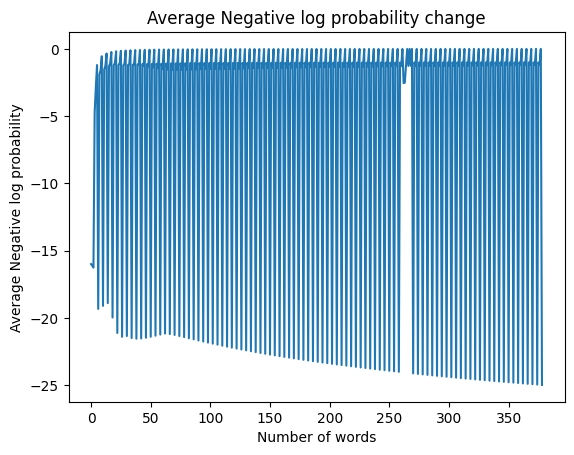

training end, matrix(2d matrix for d and f) avg score: 6.412515346718364


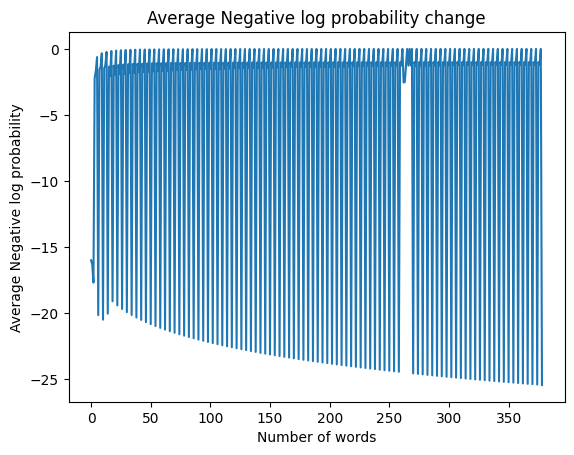

In [12]:
MAX_F = 5
MAX_M = 100

n = 1
# data = [alice]

# data = [''.join(["aba"+chr(i) for i in range(32, 127)])]
data = [''.join(["aba" + chr(i) for i in range(32, 127)])]

alpha_matrix = [[1 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix = [[0.85 for _ in range(MAX_F+1)] for _ in range(n+1)]
for i in range(2):
    trainer_matrix = Blending_with_2d_matrix(MAX_F)
    trainer_matrix.alpha_trend = []
    trainer_matrix.logs_score_individual = []
    n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    plot_score(trainer_matrix.logs_score_individual)

In [119]:
data[0][:50]

'aba aba!aba"aba#aba$aba%aba&aba\'aba(aba)aba*aba+ab'

In [123]:
# plot_score(trainer_matrix.alpha_trend)
print("alpha: ")
alpha_matrix_display = np.array(np.around(np.array(alpha_matrix),6))

print(alpha_matrix_display)

print("beta: ")
beta_matrix_display = np.array(np.around(np.array(beta_matrix),6))
print(beta_matrix_display)

alpha: 
[[ 1.96      1.96      1.96      1.063614  1.204003  1.195702  1.161302  1.120304  1.089444  1.067208  1.051074  0.044353]
 [ 3.220496  0.429186  1.758561  1.829097  1.864821  1.885734  1.899289  1.908712  1.915623  1.920902  1.92538  13.446828]]
beta: 
[[0.306    0.306    0.306    0.014277 0.031535 0.078436 0.141966 0.178085 0.201269 0.21738  0.229212 0.      ]
 [0.       0.       0.11016  0.197329 0.263181 0.292679 0.309458 0.320207 0.32766  0.333124 0.339271 0.      ]]


In [99]:
# plot_score(trainer_matrix.alpha_trend)
print("alpha: ")
alpha_matrix_display = np.array(np.around(np.array(alpha_matrix),6))

print(alpha_matrix_display)

print("beta: ")
beta_matrix_display = np.array(np.around(np.array(beta_matrix),6))
print(beta_matrix_display)

alpha: 
[[   1.4         1.4         1.4         0.049051    0.825056    0.87837     0.891933    0.900529    0.907655    0.913919    0.919494    0.      ]
 [   0.          0.          1.685944    1.834697    1.907553    2.339645    3.055356    3.419517    3.646183    3.762797    5.244604 8492.278608]]
beta: 
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [18]:
#@title different initial alpha for asyoulik

import random
MAX_F = 11
MAX_M = 100
n = 6

# load data
data = [asyoulik]
for a in [5, 10, 20, 30, 40, 50]:
    print("a: ", a)

    alpha_matrix = [[a for _ in range(MAX_F+1)] for _ in range(n+1)]
    beta_matrix = [[0.85 for _ in range(MAX_F+1)] for _ in range(n+1)]

    trainer_matrix = Blending_with_2d_matrix(MAX_F)
    n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)



    # data = ["cg"*1000]
    alpha_matrix_untrained = [[a for _ in range(MAX_F+1)] for _ in range(n+1)]
    beta_matrix_untrained = [[0.85 for _ in range(MAX_F+1)] for _ in range(n+1)]

    trainer_untrained = Blending_with_no_training(MAX_F)
    n_gram_model_untrained = trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, "words_manual_en.txt", n)
    print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
    # plot_score(trainer_untrained.logs)

    trainer_untrained.offline_optimisation(data, alpha_matrix_untrained, beta_matrix_untrained, "words_manual_en.txt", n_gram_model_untrained, n)



    # alpha_matrix = [[20 for _ in range(MAX_F+1)] for _ in range(n+1)]
    # beta_matrix = [[0.85 for _ in range(MAX_F+1)] for _ in range(n+1)]
    alpha_matrix = alpha_matrix_untrained
    beta_matrix = beta_matrix_untrained

    trainer_matrix = Blending_with_2d_matrix(MAX_F)
    n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix(2d matrix for d and f) with offline optimisation avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)

a:  5
125179
training end, matrix(2d matrix for d and f) avg score: 2.6387774541490896
constant value avg score: 2.487268455184848
125179
training end, matrix(2d matrix for d and f) with offline optimisation avg score: 9.448841026684546
a:  10
125179
training end, matrix(2d matrix for d and f) avg score: 2.4969661072867955
constant value avg score: 2.4796181840649933
125179
training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.4996911232202885
a:  20
125179
training end, matrix(2d matrix for d and f) avg score: 2.4496657939152837
constant value avg score: 2.5019732185431662
125179
training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.446062364421914
a:  30
125179
training end, matrix(2d matrix for d and f) avg score: 2.461219718563016
constant value avg score: 2.5326886865437768
125179
training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.4591431278107847
a:  40
125179
training end, matrix(2d matrix 

In [19]:
#@title try repeat compression on asyoulik

import random
MAX_F = 11
MAX_M = 100
n = 6

# load data
data = [asyoulik]
a = 20

alpha_matrix = [[a for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix = [[0.85 for _ in range(MAX_F+1)] for _ in range(n+1)]

trainer_matrix = Blending_with_2d_matrix(MAX_F)
n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
# plot_score(trainer_matrix.logs)



# data = ["cg"*1000]
alpha_matrix_untrained = [[20 for _ in range(MAX_F+1)] for _ in range(n+1)]
beta_matrix_untrained = [[0.9 for _ in range(MAX_F+1)] for _ in range(n+1)]

trainer_untrained = Blending_with_no_training(MAX_F)
n_gram_model_untrained = trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, "words_manual_en.txt", n)
print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
# plot_score(trainer_untrained.logs)

for i in range(4):
    print("iter: ", i+1)
    trainer_untrained.offline_optimisation(data, alpha_matrix_untrained, beta_matrix_untrained, "words_manual_en.txt", n_gram_model_untrained, n)

    # alpha_matrix = [[20 for _ in range(MAX_F+1)] for _ in range(n+1)]
    # beta_matrix = [[0.85 for _ in range(MAX_F+1)] for _ in range(n+1)]
    alpha_matrix = alpha_matrix_untrained
    beta_matrix = beta_matrix_untrained

    trainer_matrix = Blending_with_2d_matrix(MAX_F)
    n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix(2d matrix for d and f) with offline optimisation avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)

125179
training end, matrix(2d matrix for d and f) avg score: 2.4496657939152837
constant value avg score: 2.516225031599815
iter:  1
125179
training end, matrix(2d matrix for d and f) with offline avg score: 2.446094017488319
iter:  2
125179
training end, matrix(2d matrix for d and f) with offline avg score: 2.4407950768574955
iter:  3
125179
training end, matrix(2d matrix for d and f) with offline avg score: 2.4340344115528163
iter:  4
125179
training end, matrix(2d matrix for d and f) with offline avg score: 2.4251598608724354


In [91]:
MAX_F = 11
MAX_M = 100
n = 8

data = [alice]

alpha_matrix = [[20 for _ in range(MAX_F+1)] for _ in range(6+1)]
beta_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(6+1)]

trainer_matrix = Blending_with_2d_matrix(MAX_F)
trainer_matrix.alpha_trend = []
n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
print(f"training end, matrix(2d matrix for d and f) with offline optimisation avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
# plot_score(trainer_matrix.logs)
for i in range(5):
    for j in range(len(alpha_matrix)):
        for k in range(len(alpha_matrix[j])):
            if alpha_matrix[j][k] > 100:
                alpha_matrix[j][k] = 100
    MAX_F = 11
    MAX_M = 100
    n = 8

    data = [alice]

    # alpha_matrix = [[20 for _ in range(MAX_F+1)] for _ in range(n+1)]
    # beta_matrix = [[0.2 for _ in range(MAX_F+1)] for _ in range(n+1)]

    trainer_matrix = Blending_with_2d_matrix(MAX_F)
    trainer_matrix.alpha_trend = []
    n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix(2d matrix for d and f) with offline optimisation avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)

    print("alpha: ")
    alpha_matrix_display = np.array(np.around(np.array(alpha_matrix),6))

    print(alpha_matrix_display)

    print("beta: ")
    beta_matrix_display = np.array(np.around(np.array(beta_matrix),6))

    print(beta_matrix_display)

training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.762219202111939
training end, matrix(2d matrix for d and f) with offline optimisation avg score: 3.2326552592341473
alpha: 
[[2.00273750e+01 1.97619930e+01 2.00158010e+01 2.00149790e+01 2.00142210e+01 2.00135190e+01 2.00128670e+01 2.00122620e+01 1.99775930e+01 2.00106410e+01 1.99937250e+01 1.54031840e+01]
 [1.98999890e+01 1.79906510e+01 1.71685600e+01 1.69330820e+01 1.76084880e+01 1.61350070e+01 1.88785910e+01 1.83823540e+01 1.82496340e+01 1.89215370e+01 1.91470340e+01 1.69202030e+01]
 [1.88744030e+01 0.00000000e+00 6.78418600e+00 5.20244700e+00 1.49730990e+01 9.79052400e+00 1.47706220e+01 1.31930500e+01 1.68862560e+01 1.91206320e+01 2.36156050e+01 1.00254221e+02]
 [7.87871054e+11 0.00000000e+00 7.18536400e+00 3.20887730e+01 6.10176490e+01 3.10467410e+01 1.08676714e+02 6.05920230e+01 6.14440850e+01 3.00295500e+01 4.87314690e+01 2.11478901e+02]
 [4.23437984e+12 3.22919816e+12 6.49208840e+01 1.44016171e+02

KeyboardInterrupt: 

In [136]:
for i in range(5):
    for j in range(len(alpha_matrix)):
        for k in range(len(alpha_matrix[j])):
            if alpha_matrix[j][k] > 100:
                alpha_matrix[j][k] = 100
    MAX_F = 11
    MAX_M = 100
    n = 8

    data = [alice]

    # alpha_matrix = [[20 for _ in range(MAX_F+1)] for _ in range(n+1)]
    # beta_matrix = [[0.2 for _ in range(MAX_F+1)] for _ in range(n+1)]

    trainer_matrix = Blending_with_2d_matrix(MAX_F)
    trainer_matrix.alpha_trend = []
    n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix(2d matrix for d and f) with offline optimisation avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)

    print("alpha: ")
    alpha_matrix_display = np.array(np.around(np.array(alpha_matrix),6))

    print(alpha_matrix_display)

    print("beta: ")
    beta_matrix_display = np.array(np.around(np.array(beta_matrix),6))

    print(beta_matrix_display)

training end, matrix(2d matrix for d and f) with offline optimisation avg score: 2.168291036846579
alpha: 
[[  20.007691   19.91872    20.00463    20.004477   20.004332   20.004193   20.004061   20.003949   19.99346    20.003573   19.998864   18.394401]
 [  19.987789   19.316603   19.037723   18.929933   19.170758   18.624497   19.461979   19.421512   19.351008   19.604923   19.67565    17.960897]
 [  19.633262    6.641358   37.884481   12.21311    14.384072   14.937661   16.798487   17.057966   18.128126   18.938517   19.652344   85.246893]
 [  18.666825    1.358765    2.733082   76.984222   22.788087   17.042872   61.572541   22.591893   23.940483   20.565175  101.128965  119.394091]
 [  89.018923    2.449181   95.887979   63.56598    22.212051   23.235124   28.164178   20.726707   31.447619   30.961843   77.123876 1090.321977]
 [ 127.089799    4.127112   64.802015   29.671173   26.130094   31.295962   22.817905   22.599536   23.064772   21.474717   22.039438 3385.750648]
 [ 227.5000

In [14]:
#@title words from texts

import random
MAX_F = 11
MAX_M = 100
n = 6

print("runing on text files")

texts = {"alice29": alice, "lcet10": lcet, "plrabn12": plrabn12, "asyoulik": asyoulik}

# load data
for id in texts:

    data = [texts[id][:1000]]
    print(f"runing on file: {id}")
    print()

    alpha_matrix_linear = [[0.5]]
    beta_matrix_linear = [[0.75]]

    trainer_one_param = Blending_with_one_alpha_beta(MAX_F)
    n_gram_model_linear = trainer_one_param.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, one param(1 alpha and beta for all calculation) avg score: {-trainer_one_param.total_score/trainer_one_param.count}")
    # plot_score(trainer_one_param.logs)

    alpha_matrix_linear = [[0.5, 0] for _ in range(n+1)]
    beta_matrix_linear = [[0.75, 0] for _ in range(n+1)]

    trainer_linear = Blending_with_linear_param(MAX_F)
    n_gram_model_linear = trainer_linear.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, linear(alpha = p0d + p1d * f) avg score: {-trainer_linear.total_score/trainer_linear.count}")
    # plot_score(trainer_linear.logs)

    alpha_matrix_linear = [0.5, 0, 0]
    beta_matrix_linear = [0.75, 0, 0]

    trainer_linear_v2 = Blending_with_linear_param_v2(MAX_F, n)
    n_gram_model_linear = trainer_linear_v2.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, linear v2(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2.total_score/trainer_linear_v2.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_d(MAX_F, n, 1)
    n_gram_model_linear = trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, linear v2 piecewise on d, first one row(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_d(MAX_F, n, 2)
    n_gram_model_linear = trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, linear v2 piecewise on d, first two rows(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_f(MAX_F, n, 1)
    n_gram_model_linear = trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, linear v2 piecewise on f, first one column(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(n+1)]
    beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

    trainer_matrix = Blending_with_2d_matrix(MAX_F)
    n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)

    alpha_matrix = [[0.5 for _ in range(MAX_M+1)] for _ in range(n+1)]
    beta_matrix = [[0.75 for _ in range(MAX_M+1)] for _ in range(n+1)]

    trainer_matrix_v2 = Blending_with_2d_matrix_v2(MAX_F, MAX_M)
    n_gram_model_matrix = trainer_matrix_v2.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix v2(2d matrix for d and m) avg score: {-trainer_matrix_v2.total_score/trainer_matrix_v2.count}")
    # plot_score(trainer_matrix_v2.logs)

    # alpha_matrix = [[[0.5 for _ in range(MAX_M+1)] for _ in range(MAX_F+1)] for _ in range(n+1)]
    # beta_matrix = [[[0.75 for _ in range(MAX_M+1)] for _ in range(MAX_F+1)] for _ in range(n+1)]

    # trainer_matrix_v3 = Blending_with_2d_matrix_v3(MAX_F, MAX_M)
    # n_gram_model_matrix = trainer_matrix_v3.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    # print(f"training end, matrix v3(3d matrix for d, f, m) avg score: {-trainer_matrix_v3.total_score/trainer_matrix_v3.count}")
    # # plot_score(trainer_matrix_v3.logs)

    alpha_matrix_untrained = [[0.5 for _ in range(MAX_F+1)] for _ in range(n+1)]
    beta_matrix_untrained = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

    trainer_untrained = Blending_with_no_training(MAX_F)
    n_gram_model_untrained = trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, "words_manual_en.txt", n)
    print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
    # plot_score(trainer_untrained.logs)

    print()

runing on text files
runing on file: alice29

training end, one param(1 alpha and beta for all calculation) avg score: 5.89624218149458
training end, linear(alpha = p0d + p1d * f) avg score: 4.79666315307701
training end, linear v2(alpha = p0 + p1 * d + p2 * f) avg score: 4.757521092991976
training end, linear v2 piecewise on d, first one row(alpha = p0 + p1 * d + p2 * f) avg score: 4.842241474800649
training end, linear v2 piecewise on d, first two rows(alpha = p0 + p1 * d + p2 * f) avg score: 4.854198832300867
training end, linear v2 piecewise on f, first one column(alpha = p0 + p1 * d + p2 * f) avg score: 4.756475489428413
training end, matrix(2d matrix for d and f) avg score: 5.169474985303712
training end, matrix v2(2d matrix for d and m) avg score: 5.561299353641685
constant value avg score: 4.911444628995105

runing on file: lcet10

training end, one param(1 alpha and beta for all calculation) avg score: 5.401221467939197
training end, linear(alpha = p0d + p1d * f) avg score: 4.

In [13]:
#@title words from binary

import random
MAX_F = 11
MAX_M = 100
n = 6

print("runing on binary files")

# binarys = {"sum": sum_file, "ptt5": ptt5}
binarys = {"sum": sum_file}

# load data
for id in binarys:

    data = [binarys[id][:1000]]
    print(f"runing on file: {id}")
    print()

    alpha_matrix_linear = [[0.5]]
    beta_matrix_linear = [[0.75]]

    trainer_one_param = Blending_with_one_alpha_beta(MAX_F)
    n_gram_model_linear = trainer_one_param.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, one param(1 alpha and beta for all calculation) avg score: {-trainer_one_param.total_score/trainer_one_param.count}")
    # plot_score(trainer_one_param.logs)

    alpha_matrix_linear = [[0.5, 0] for _ in range(n+1)]
    beta_matrix_linear = [[0.75, 0] for _ in range(n+1)]

    trainer_linear = Blending_with_linear_param(MAX_F)
    n_gram_model_linear = trainer_linear.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, linear(alpha = p0d + p1d * f) avg score: {-trainer_linear.total_score/trainer_linear.count}")
    # plot_score(trainer_linear.logs)

    alpha_matrix_linear = [0.5, 0, 0]
    beta_matrix_linear = [0.75, 0, 0]

    trainer_linear_v2 = Blending_with_linear_param_v2(MAX_F, n)
    n_gram_model_linear = trainer_linear_v2.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, linear v2(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2.total_score/trainer_linear_v2.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_d(MAX_F, n, 1)
    n_gram_model_linear = trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, linear v2 piecewise on d, first one row(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_d(MAX_F, n, 2)
    n_gram_model_linear = trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, linear v2 piecewise on d, first two rows(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix_linear = [[0.5, 0, 0] for _ in range(2)]
    beta_matrix_linear = [[0.75, 0, 0] for _ in range(2)]

    trainer_linear_v2_piecewise = Blending_with_linear_param_v2_piecewise_f(MAX_F, n, 1)
    n_gram_model_linear = trainer_linear_v2_piecewise.build_model_with_train(data, alpha_matrix_linear, beta_matrix_linear, "words_manual_en.txt", n)
    print(f"training end, linear v2 piecewise on f, first one column(alpha = p0 + p1 * d + p2 * f) avg score: {-trainer_linear_v2_piecewise.total_score/trainer_linear_v2_piecewise.count}")
    # plot_score(trainer_linear_v2.logs)

    alpha_matrix = [[0.5 for _ in range(MAX_F+1)] for _ in range(n+1)]
    beta_matrix = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

    trainer_matrix = Blending_with_2d_matrix(MAX_F)
    n_gram_model_matrix = trainer_matrix.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix(2d matrix for d and f) avg score: {-trainer_matrix.total_score/trainer_matrix.count}")
    # plot_score(trainer_matrix.logs)

    alpha_matrix = [[0.5 for _ in range(MAX_M+1)] for _ in range(n+1)]
    beta_matrix = [[0.75 for _ in range(MAX_M+1)] for _ in range(n+1)]

    trainer_matrix_v2 = Blending_with_2d_matrix_v2(MAX_F, MAX_M)
    n_gram_model_matrix = trainer_matrix_v2.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix v2(2d matrix for d and m) avg score: {-trainer_matrix_v2.total_score/trainer_matrix_v2.count}")
    # plot_score(trainer_matrix_v2.logs)

    alpha_matrix = [[[0.5 for _ in range(MAX_M+1)] for _ in range(MAX_F+1)] for _ in range(n+1)]
    beta_matrix = [[[0.75 for _ in range(MAX_M+1)] for _ in range(MAX_F+1)] for _ in range(n+1)]

    trainer_matrix_v3 = Blending_with_2d_matrix_v3(MAX_F, MAX_M)
    n_gram_model_matrix = trainer_matrix_v3.build_model_with_train(data, alpha_matrix, beta_matrix, "words_manual_en.txt", n)
    print(f"training end, matrix v3(3d matrix for d, f, m) avg score: {-trainer_matrix_v3.total_score/trainer_matrix_v3.count}")
    # plot_score(trainer_matrix_v3.logs)

    alpha_matrix_untrained = [[0.5 for _ in range(MAX_F+1)] for _ in range(n+1)]
    beta_matrix_untrained = [[0.75 for _ in range(MAX_F+1)] for _ in range(n+1)]

    trainer_untrained = Blending_with_no_training(MAX_F)
    n_gram_model_untrained = trainer_untrained.build_model_with_train(data, alpha_matrix_untrained, beta_matrix_untrained, "words_manual_en.txt", n)
    print(f"constant value avg score: {-trainer_untrained.total_score/trainer_untrained.count}")
    # plot_score(trainer_untrained.logs)

    print()

runing on binary files


NameError: name 'sum_file' is not defined